In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import requests
from bs4 import BeautifulSoup as bs

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

### Задание №1

Необходимо собрать информацию о вакансиях на должность программиста или разработчика с сайта job.ru или hh.ru. (Можно с обоих сразу) Приложение должно анализировать несколько страниц сайта. Получившийся список должен содержать в себе: 
* Наименование вакансии;
* Предлагаемую зарплату;
* Ссылку на саму вакансию.

Задаем искомые параметры для поиска: название вакансии, глубина поиска (до какой страницы hh.ru производить поиск), период анализа в днях

In [2]:
vacancy_name = 'python'
search_depth = 2
analysis_period = 10

Получаем ссылку для выполнения поиска

In [3]:
hh_url = 'https://hh.ru/search/vacancy?search_period='+str(analysis_period)+'&text='+vacancy_name+'&area=1'

Чтобы обойти блокировку hh.ru от автоматического парсинга, пытаемся выдать себя за человека, задав заголовок и создав сессию

In [4]:
headers = {'accept': '*/*',
           'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.1.1 Safari/605.1.15'}

session = requests.session()

In [5]:
n = 0
titles = []
salarys = []
hrefs = []

while n < search_depth:
    request = session.get(hh_url+'&page='+str(n), headers=headers)
    
    hh_html = bs(request.content, 'html.parser')
    divs = hh_html.find_all('div', attrs={'data-qa': 'vacancy-serp__vacancy'})

    for div in divs:
        title = div.find('a', attrs={'data-qa': 'vacancy-serp__vacancy-title'}).text
        salary = div.find('div', attrs={'data-qa': 'vacancy-serp__vacancy-compensation'})

        if salary == None:
            salary = 'Не указанно'
        else:
            salary = div.find('div', attrs={'data-qa': 'vacancy-serp__vacancy-compensation'}).text
        
        href = div.find('a', attrs={'data-qa': 'vacancy-serp__vacancy-title'})['href']
        
        titles.append(title)
        salarys.append(salary)
        hrefs.append(href)
        
        print(f'Вакансия: {title}\nПредлагаемая зарплата: {salary}\nСсылка: {href}\n\n')
    
    n += 1

Вакансия: Разработчик Python
Предлагаемая зарплата: 160 000-200 000 руб.
Ссылка: https://vidnoe.hh.ru/vacancy/31624245?query=python


Вакансия: Ведущий Python разработчик
Предлагаемая зарплата: 150 000-250 000 руб.
Ссылка: https://vidnoe.hh.ru/vacancy/32061372?query=python


Вакансия: Программист Python
Предлагаемая зарплата: от 150 000 руб.
Ссылка: https://vidnoe.hh.ru/vacancy/32304134?query=python


Вакансия: Разработчик Python
Предлагаемая зарплата: 120 000-180 000 руб.
Ссылка: https://vidnoe.hh.ru/vacancy/30451399?query=python


Вакансия: Python developer (Библиотеки для автотестирования)
Предлагаемая зарплата: от 4 000 USD
Ссылка: https://vidnoe.hh.ru/vacancy/30005963?query=python


Вакансия: Программист Python
Предлагаемая зарплата: 100 000-180 000 руб.
Ссылка: https://vidnoe.hh.ru/vacancy/32139253?query=python


Вакансия: Разработчик Python
Предлагаемая зарплата: от 140 000 руб.
Ссылка: https://vidnoe.hh.ru/vacancy/31194079?query=python


Вакансия: Python-разработчик
Предлагаема

Немного поиграемся с полученными данными

In [6]:
df = pd.DataFrame({'Title': titles,
                   'Salary': salarys,
                   'Href': hrefs}, columns=['Title', 'Salary', 'Href'])

Почистим и сгруппируем данные, чтобы можно было посмотреть количество вакансий в ценовых диапазонах

In [7]:
df.replace(u'\xa0',u'', regex=True, inplace=True)

In [8]:
df.groupby('Salary', as_index=False).size()

Salary
100000-180000 руб.    1
120000-180000 руб.    1
120000-200000 руб.    1
150000-200000 руб.    1
150000-220000 руб.    1
150000-230000 руб.    1
150000-250000 руб.    1
160000-200000 руб.    1
160000-250000 руб.    1
180000-230000 руб.    1
2000-3000 EUR         1
200000-300000 руб.    1
300000-400000 руб.    1
40000-60000 руб.      1
60000-100000 руб.     1
80000-120000 руб.     1
80000-130000 руб.     1
80000-140000 руб.     1
90000-140000 руб.     1
Не указанно           9
до 130000 руб.        1
от 100000 руб.        2
от 130000 руб.        1
от 140000 руб.        1
от 150000 руб.        1
от 180000 руб.        1
от 4000 USD           1
от 95000 руб.         1
dtype: int64

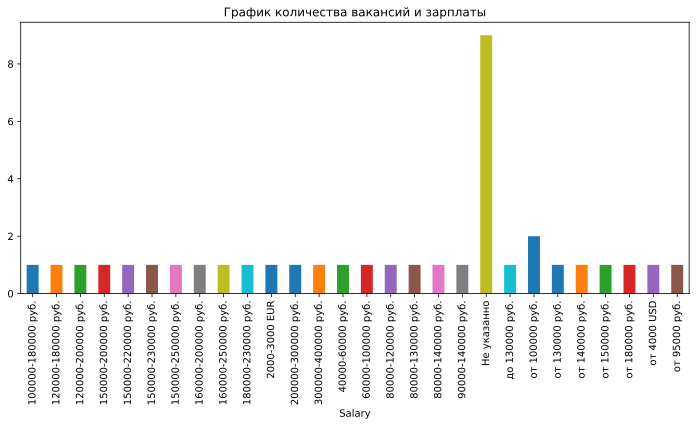

In [9]:
rcParams['figure.figsize'] = 12, 5
df.groupby('Salary', as_index=True).size().plot(kind='bar', title='График количества вакансий и зарплаты')

Как наглядно видно из графика, для большей части вакансий не указан размер зарплаты

In [10]:
writer = pd.ExcelWriter('output.xlsx')
df.to_excel(writer, 'Сведения по вакансии')
writer.save()

### Задание №2

Доработать приложение таким образом, чтобы можно было искать разработчиков на разные языки программирования (Например Python, Java, C++)

In [11]:
def hh_parse(vacancy_name, search_depth, analysis_period):
    n = 0
    titles = []
    salarys = []
    hrefs = []
    
    hh_url = 'https://hh.ru/search/vacancy?search_period='+str(analysis_period)+'&text='+vacancy_name+'&area=1'
    headers = {'accept': '*/*',
           'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.1.1 Safari/605.1.15'}
    
    while n < search_depth:
        request = session.get(hh_url+'&page='+str(n), headers=headers)
        hh_html = bs(request.content, 'html.parser')
        divs = hh_html.find_all('div', attrs={'data-qa': 'vacancy-serp__vacancy'})
        for div in divs:
            title = div.find('a', attrs={'data-qa': 'vacancy-serp__vacancy-title'}).text
            salary = div.find('div', attrs={'data-qa': 'vacancy-serp__vacancy-compensation'})
            if salary == None:
                salary = 'Не указанно'
            else:
                salary = div.find('div', attrs={'data-qa': 'vacancy-serp__vacancy-compensation'}).text

            href = div.find('a', attrs={'data-qa': 'vacancy-serp__vacancy-title'})['href']
            titles.append(title)
            salarys.append(salary)
            hrefs.append(href)
        n += 1
    df = pd.DataFrame({'Title': titles,
                       'Salary': salarys,
                       'Href': hrefs}, columns=['Title', 'Salary', 'Href'])
    return df

In [12]:
vacancy_name = input('Введите название вакансии для поиска: ')

Введите название вакансии для поиска: Data Science


In [13]:
search_depth = int(input('Введите глубину поиска (количество страниц): '))

Введите глубину поиска (количество страниц): 4


In [14]:
analysis_period = int(input('Введите период анализа (количество дней): '))

Введите период анализа (количество дней): 30


In [15]:
hh_frame = hh_parse(vacancy_name, search_depth, analysis_period)

In [16]:
hh_frame

,Title,Salary,Href
0,Data Science Team Lead,Не указанно,https://vidnoe.hh.ru/vacancy/30821952?query=Da...
1,Аналитик данных / Data Scientist,80 000-300 000 руб.,https://vidnoe.hh.ru/vacancy/31887942?query=Da...
2,Senior Data Scientist,Не указанно,https://vidnoe.hh.ru/vacancy/32194771?query=Da...
3,Data Scientist Head,Не указанно,https://vidnoe.hh.ru/vacancy/32296115?query=Da...
4,Data Scientist,Не указанно,https://vidnoe.hh.ru/vacancy/25473334?query=Da...
5,Data Scientist,Не указанно,https://vidnoe.hh.ru/vacancy/31552816?query=Da...
6,Менеджер по обработке и анализу данных / Data ...,50 000-80 000 руб.,https://vidnoe.hh.ru/vacancy/32035787?query=Da...
7,Ассистент по анализу данных и визуализации / D...,от 30 000 руб.,https://vidnoe.hh.ru/vacancy/32047321?query=Da...
8,Data Scientist,Не указанно,https://vidnoe.hh.ru/vacancy/31439575?query=Da...
9,Data Scientist,Не указанно,https://vidnoe.hh.ru/vacancy/32285085?query=Da...
